In [1]:
!wget -O ./data/moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ./data/moviedataset.zip -d ./data

--2019-12-14 21:12:01--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./data/moviedataset.zip’

./data/moviedataset 100%[===================>]   5.64M  11.6MB/s    in 0.5s    

2019-12-14 21:12:01 (11.6 MB/s) - ‘./data/moviedataset.zip’ saved [5917549/5917549]

Archive:  ./data/moviedataset.zip
   creating: ./data/ml-1m/
  inflating: ./data/ml-1m/movies.dat  
  inflating: ./data/ml-1m/ratings.dat  
  inflating: ./data/ml-1m/README     
  inflating: ./data/ml-1m/users.dat  


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Loading in the movies dataset
movies_df = pd.read_csv('./data/ml-1m/movies.dat', sep='::', header=None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
#Loading in the ratings dataset
ratings_df = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
len(movies_df)

3883

In [8]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)
vb = tf.placeholder("float", [visibleUnits]) #Number of unique movies
hb = tf.placeholder("float", [hiddenUnits]) #Number of features we're going to learn
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

In [11]:
#Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [12]:
#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [13]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [14]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.059384685
0.05078424
0.04937715
0.04769935
0.047150217
0.04639397
0.046132077
0.0459253
0.045698512
0.045365818
0.045347713
0.045386616
0.04517124
0.04493864
0.044994056


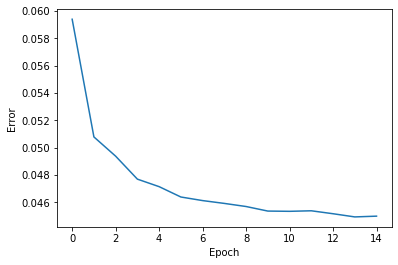

In [15]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [16]:
mock_user_id = 215

In [17]:
#Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [18]:
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
print(rec)

[[0.5009361  0.09660584 0.01016435 ... 0.00247247 0.00138379 0.00872269]]


In [19]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.997582
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.973734
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.930294
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.890734
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,0.861420
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.804818
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.796880
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.785737
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.761427
1335,1356,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi,0.728276


In [20]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]
movies_df_mock.head()

,UserID,MovieID,Rating,Timestamp
31603,215,3793,5,977099259
31604,215,1,4,979174987
31605,215,1197,5,976899663
31606,215,2302,5,976899718
31607,215,2167,5,976899770


In [ ]:
#Merging movies_df with ratings_df by MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

In [ ]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)